In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host='localhost',
    user='root',
    password='Kashyap@mysql888',
    database='ecommerce'
)

cur=db.cursor()

print("Connected")

# 1. List all unique cities where customers are located

In [ ]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
data

# 2. Count the number of orders placed in 2017

In [ ]:
Query=""" select count(order_id) from orders where year(order_purchase_timestamp)='2017' """
cur.execute(Query)
data=cur.fetchall()
"total orders placed in 2017 are", data[0][0]

# 3. Find the total sales per category

In [ ]:
Query=""" select products.product_category as category,round(sum(payments.payment_value)) as sales from  products 
join orderitems ON
products.product_id=orderitems.product_id
JOIN
payments on
payments.order_id=orderitems.order_id
group by category """
cur.execute(Query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Sales"])
df

# 4. Calculate the percentage of orders that were paid in installments

In [23]:
Query=""" select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments """
cur.execute(Query)
data=cur.fetchall()
'the percentage of orders that were paid in installments', data
df=pd.DataFrame(data, columns=['Percentage'])
df

,Percentage
0,99.9981


# 5. Count the number of customers from each state

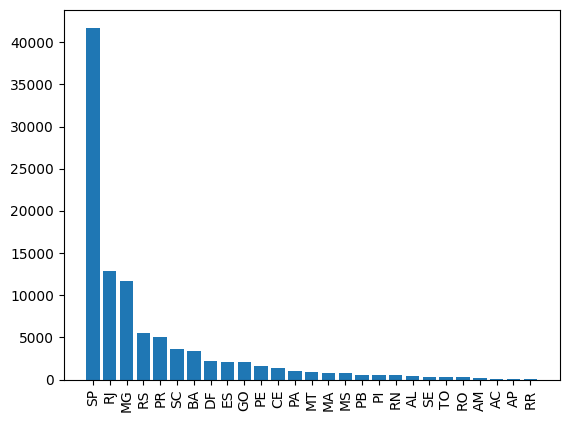

In [24]:
Query=""" select customer_state,count(customer_id) from customers group by customer_state """
cur.execute(Query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["State","Count"])
df=df.sort_values(by= "Count" , ascending=False) 
plt.bar (df['State'], df['Count'])
plt.xticks(rotation=90)
plt.show()

# 6.Calculate the number of orders per month in 2018

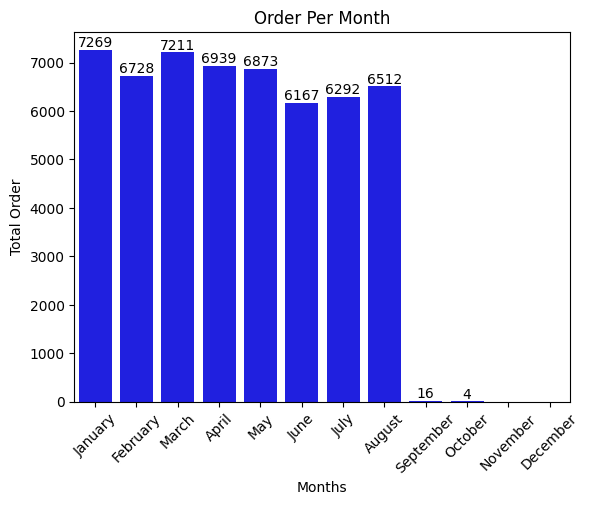

In [25]:
Query=""" Select COUNT(order_id), MONTHNAME(order_purchase_timestamp) from orders where YEAR(order_purchase_timestamp)=2018
group by  MONTHNAME(order_purchase_timestamp)  """
cur.execute(Query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Total Order","Months"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
#ax=sns.barplot(x= df["Months"], y=df["Total Order"], data=df, order=o, hue=df["Months"], palette='viridis')
ax=sns.barplot(x= df["Months"], y=df["Total Order"], data=df, order=o, color='Blue')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
#plt.xlabel("Months")
#plt.ylabel("Total")
plt.title("Order Per Month")
plt.show()

# 7.Find the average number of products per order, grouped by customer city

In [ ]:
query=""" with Count_orders as(
select orders.order_id,orders.customer_id, count(orderitems.order_id) as oc
from orders JOIN orderitems on
orders.order_id=orderitems.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(Count_orders.oc),2) as avg_orders
from customers JOIN Count_orders ON
customers.customer_id=Count_orders.customer_id
group by customers.customer_city
order by avg_orders DESC
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['City','Avg_Orders'])
df.head(10)


# 8.Calculate the percentage of total revenue contributed by each product category

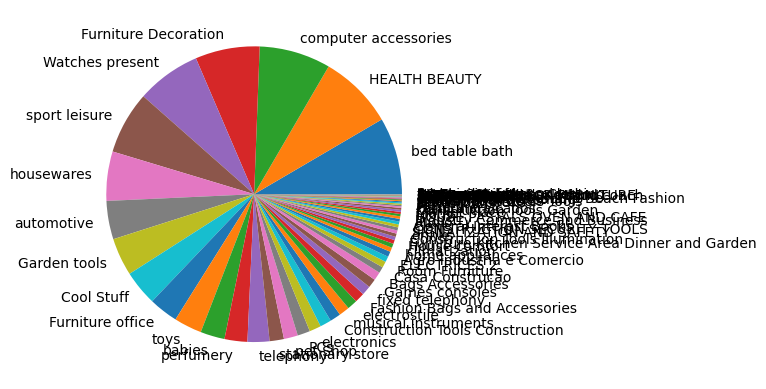

In [30]:
Query=""" select products.product_category as Category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
 from products
JOIN orderitems ON
products.product_id=orderitems.product_id JOIN payments ON
payments.order_id=orderitems.order_id
group by Category
order by sales_percentage DESC """
cur.execute(Query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Category','Sales_percentage'])
plt.pie(df['Sales_percentage'], labels= df['Category'])
plt.show()

# 9.Identify the correlation between product price and the number of times a product has been purchased

In [ ]:
query=""" select products.product_category as Category,
count(orderitems.product_id), round(avg(orderitems.price),2)
 from products
JOIN orderitems ON
products.product_id=orderitems.product_id 
group by Category
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Category','Count','Avg_Price'])
arr1=df['Count']
arr2=df['Avg_Price']
a=np.corrcoef([arr1,arr2])
print("Correlation between product price and the number of times a product has been purchased is",a[0][-1])

# 10.Calculate the total revenue generated by each seller, and rank them by revenue

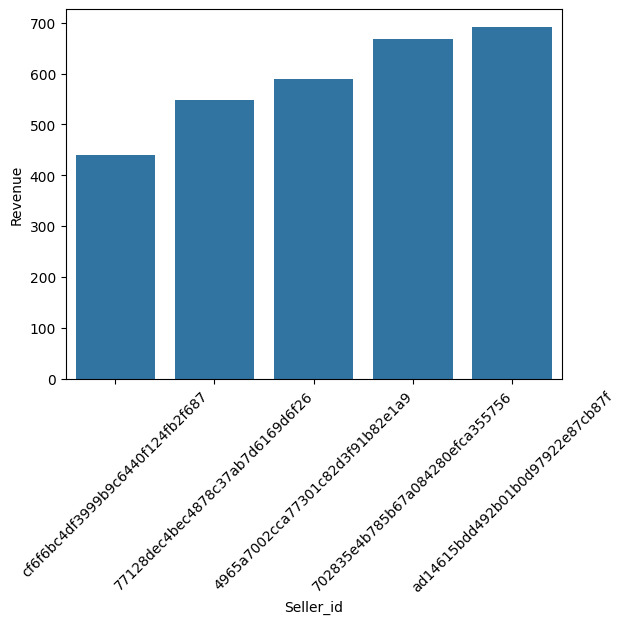

In [27]:
query=""" select *, dense_rank() over(order by revenue) as rn from
(select orderitems.seller_id,sum(payments.payment_value) as revenue from orderitems
JOIN payments ON
orderitems.order_id=payments.order_id
group by orderitems.seller_id) as a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Seller_id','Revenue','Rank'])
df=df.head()
sns.barplot(x='Seller_id',y='Revenue', data=df)
plt.xticks(rotation=45)
plt.show()

# 11.Calculate the moving average of order values for each customer over their order history

In [ ]:
query=""" select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp  rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments JOIN orders ON
payments.order_id=orders.order_id) a """
cur.execute(query)
data=cur.fetchall()
data


# 12.Calculate the cumulative sales per month for each year

In [ ]:
query="""select Year,Month, payment,sum(payment) over (order by YEAR,MONTH) as cummilative from
(select YEAR(order_purchase_timestamp) Year, MONTH(order_purchase_timestamp) Month, round(sum(payments.payment_value),2) as payment
from orders JOIN payments ON
orders.order_id=payments.order_id
group by YEAR,MONTH
order by YEAR,MONTH) as a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

# 13.Calculate the year-over-year growth rate of total sales

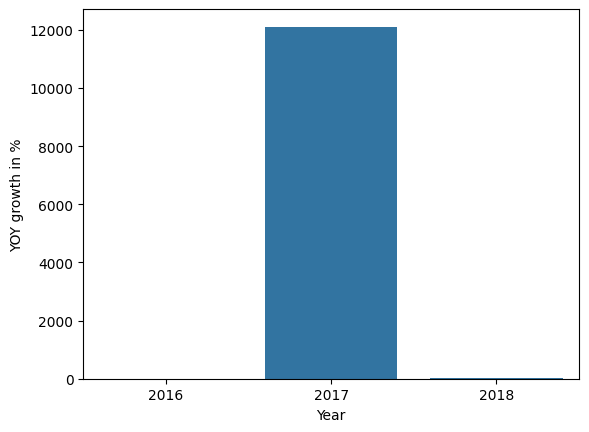

In [28]:
query="""with CTE as(select YEAR(order_purchase_timestamp) Year,round(sum(payments.payment_value),2) as payment
from orders JOIN payments ON
orders.order_id=payments.order_id
group by YEAR
order by YEAR)
select year,((payment-lag(payment,1) over(order by year))/(lag(payment,1) over(order by year)))* 100 as yoy_growth  from CTE"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Year','YOY growth in %'])
sns.barplot(x='Year',y='YOY growth in %', data=df)
plt.show()

# 14.Identify the top 3 customers who spent the most money in each year.

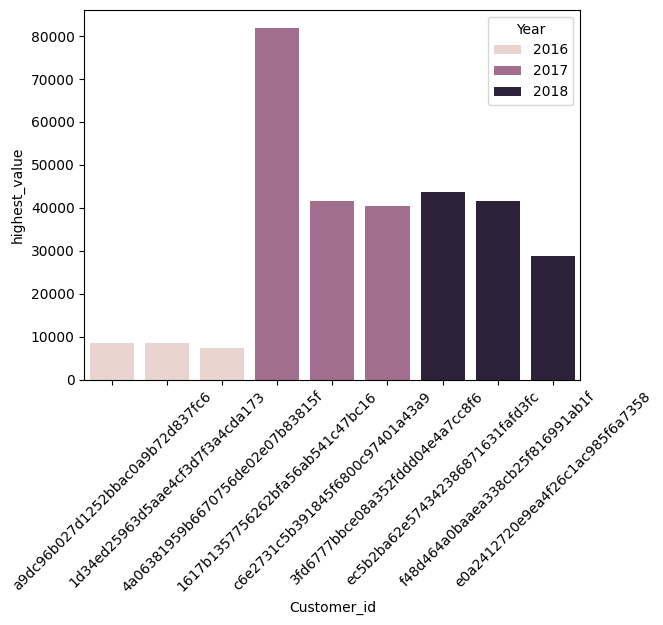

In [29]:
query=""" with CTE as (select YEAR(orders.order_purchase_timestamp) as Year,orders.customer_id, sum(payments.payment_value) as highest_value,
dense_rank() over (partition by YEAR(orders.order_purchase_timestamp) order by sum(payments.payment_value) DESC) as ra
from orders join payments on
orders.order_id=payments.order_id
group by Year,orders.customer_id)

select Year,Customer_id,round(highest_value,2) from CTE where ra<=3 """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Year','Customer_id','highest_value'])
sns.barplot(x="Customer_id",y="highest_value",data=df, hue='Year')
plt.xticks(rotation=45)
plt.show()
